# Segmenting and Clustering Niehborhoods in Toronto

### Introduction

### (Web-Scraping, Foursquare API, Folium Map, Kmeans Clustering & Machine Learning)

### In this assignment, we convert addresses into their equivalent latitude and longitude values. We use the Foursquare API to explore neighborhoods in Toronto. We use the explore function to get the most  common venue categories in each neighborhood, and then use this feature to group the neighborhoods into clusters. We use the k-means clustering algorithm to complete this task. Finally, we use the Folium library to visualize the neighborhoods in Toronto and their emerging clusters.

### Toronto Nighborhood data is available on wikipedia.  We will scrape the wiki-page, wrangle and clean the data and assign it to a panadas dataframe.

### Once the data is formatted into a proper structure, we will explore and cluster Toronto's various neighborhoods.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>   
    
##### <a href="#item1"> Part 1 - Scraping from web and transforming data</a>
    
<a href="#item1b"> 1b - Preprocessing</a>
    
##### <a href="#item2"> Part 2 - Geocoder, assigning latitude and longitude to postal codes</a>

##### <a href="#item3"> Part 3 - Explore and cluster the neighborhoods of Toronto</a>
    
<a href="#item3b"> 3b. FourSquare API </a>
    
<a href="#item3c"> 3c. Explore Neighborhoods in the chosen Borough </a>
    
<a href="#item3d"> 3d. Analyze Each Neighborhood </a> 
    
<a href="#item3e"> 3e. Cluster Nieghborhoods </a>
    
<a href="#item3f"> 3f. Examine the Clusters </a>    
    
    
    
    
    
    
    
    
    
   
    
 
</font>
</div>

First download and import required dependencies.

In [1]:
!pip install --user beautifulsoup4

In [2]:
!pip install --user lxml

In [3]:
!pip install --user requests

In [4]:
!pip install --user geopy

In [5]:
!pip install --user folium

In [6]:
!pip install --user geocoder

In [7]:
!pip install sklearn

In [8]:
!pip install KMeans

In [9]:
!pip install yellowbrick

In [10]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import for scraping data from web
from bs4 import BeautifulSoup 
import requests
import csv

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import geocoder #import the geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans
import kmeans
from yellowbrick.cluster import KElbowVisualizer

print('Libraries imported.')

Libraries imported.


### <a id='item1'> Part 1a - Scraping from web and transforming data</a>

Here we scrape the data using beautifulsoup library and convert it to a dataset.

In [11]:
#Scrape postal code and nighborhood data for Toronto from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url)
toronto_html = BeautifulSoup(source.content)

In [12]:
soup = BeautifulSoup(source.text, 'lxml')

In [13]:
table = soup.find_all('table')[0]

In [14]:
# import the HTML table into a DataFrame
dfs = pd.read_html(str(table), header = 0)

In [15]:
# assign the data frame to pandas dataframe
df = dfs[0]

In [16]:
df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### <a id='item1b'> 1b. Preprocssing </a>

In [17]:
df.shape

(180, 3)

In [18]:
# rename columns headers
df.columns = ['PostalCode', 'Borough', 'Neighborhood']

Check for 'not assigned' boroughs to be removed

In [19]:
df.Borough.value_counts()

Not assigned        77
North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
York                 5
East York            5
Mississauga          1
Name: Borough, dtype: int64

In [20]:
# Remove Boroughs that are 'not assigned'
df = df[df['Borough'] != 'Not assigned']

In [21]:
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Confirm not assigned were removed.

In [22]:
df.Borough.value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East York            5
East Toronto         5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In [23]:
df.shape

(103, 3)

Here we copy Borough names to Neighborhoods without an assigned name.

In [24]:
df['Neighborhood'] = df['Borough'].where(df['Neighborhood'] == 'Not assigned', df['Neighborhood'])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now we will group all duplicated postal codes, any duplicate neighborhood will be listed on the same line seperated by ",'s'".

In [25]:
# join neighborhoods with the same postalcode and borough
grouped = df.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(lambda x: ', '.join(x))

# convert a groupby object to dataframe
grouped.reset_index()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [26]:
df_nbh = pd.DataFrame(grouped)
dfnbh = df_nbh.reset_index()
dfnbh.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Next we check to see if any duplicate postal codes/neihgborhoods persist. 

In [27]:
print(dfnbh)

    PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North 

In [28]:
dfnbh.shape

(103, 3)

The Toronto neighborhood data set is now ready.  Next we will add geolocater data to the dataframe.

### <a id='item2'> Part 2a - Geocoder, assigning latitude and longitude to postal codes</a>

In order to utilize Foursquare location data we must have latidtude and longitude coordinates of each neighborhood.  We source this data from the provided geospatial data set: "https://cocl.us/Geospatial_data".
(It is to be noted that a more rubust alternative would be to use an API provider of geospatial data such as Google, however, this is a cost free alternative.)

In [29]:
geo_url = "https://cocl.us/Geospatial_data"

geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the geo data set to our Toronto data set

In [30]:
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Great! Now we have the date set with the required parameters needed to explore Toronto Neighborhoods using FourSquare.

### <a id='item3'> Part 3a - Explore and cluster the neighborhoods of Toronto</a>

Using geopy library we get the latitude and longitude values of Toronto.

In [31]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Create a map of Toronto

In [32]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

To simplify the map, segementing and clustering we'll focus on Toronto Downtown.  Here we slice the existing dataframe to create a Dowtown Toronto dataframe.

In [33]:
dtt_df = df[df['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
dtt_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


Let's get geo-coordinates for the chosen slice.

In [34]:
address = 'Downtown Toronto, Toronto'

geolocator = Nominatim(user_agent="dt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


Visualize Downtown Toronto neighborhoods

In [35]:
# create map of Downtown Toronto using latitude and longitude values
map_dtt = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(dtt_df['Latitude'], dtt_df['Longitude'], dtt_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dtt)  
    
map_dtt

Next we will utilize the Foursquare API to explore and segment the neighborhoods.

### <a id='item3b'> 3b. FourSquare API </a>

Define Foursquare credentials and version

In [2]:
# The code was removed by Watson Studio for sharing.

Your credentails: are stored and hidden


Explore the first neighborhood in the dataframe of the chosen slice.

In [37]:
dtt_df.loc[0, 'Neighborhood']

'Regent Park, Harbourfront'

Get the geo-coordinates of the first neighborhood

In [38]:
neighborhood_latitude = dtt_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dtt_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dtt_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))


Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


Let's ask, what are the top 100 venues with a 500 meter radious to this neighborhood?

Create a the GET request URL and name it url.

In [39]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=YKGLV4QIJHZF4LIPZQF0NH5PPUWWQ1GH3LZ5E1TLGYRMSN3B&client_secret=OMJBFYAWVR5DSKHM01QVO3ZJWX5SXJYEESKAIE3RMZCTYP3K&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

Send and examine the results.

In [40]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f08afc23ed7e05ec456f6b7'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 45,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '54ea41ad498e9a11e9e13308',
       'name': 'Roselle Desserts',
       'location': {'address': '362 King St E',
        'crossStreet': 'Trinity St',
        'lat': 43.653446723052674,
        'lng': -79.3620167174383,
        'labeledLatLngs': [{'label': 'display',
 

Foursquare provides info in items key, next we'll borrow the get_category_type function from Foursqure lab.

In [41]:
# Foursquare function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we're ready to clean and structure the json into a pandas dataframe

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Corktown Common,Park,43.655618,-79.356211


Let's see how many venues were returned by Foursquare.

In [43]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

45 venues were returned by Foursquare.


### <a id='item3c'> 3c. Exlpore Neighborhoods in the chosen Borough </a>

Let's create a funtion to repeat the same function to all neighborhoods within the selected borough.

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The following code will run the above function on each neighborhood and create a new datafram called dtt_venues.

In [46]:
dtt_venues = getNearbyVenues(names=dtt_df['Neighborhood'],
                                   latitudes=dtt_df['Latitude'],
                                   longitudes=dtt_df['Longitude']
                                  )


Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


Let's have a look at the size of the data frame.

In [47]:
print(dtt_venues.shape)
dtt_venues.head()

(1228, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


Let's see how many venues there are per neighborhood.

In [48]:
dtt_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,58,58,58,58,58,58
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",14,14,14,14,14,14
Central Bay Street,70,70,70,70,70,70
Christie,16,16,16,16,16,16
Church and Wellesley,71,71,71,71,71,71
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
"First Canadian Place, Underground city",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"Harbourfront East, Union Station, Toronto Islands",100,100,100,100,100,100


Let's see how many unique categories can be observed.

In [49]:
print('There are {} uniques categories.'.format(len(dtt_venues['Venue Category'].unique())))

There are 206 uniques categories.


### <a id='item3d'> 3d. Analyze Each Neighborhood  </a>

Let's creat a dataframe with neighborhoods and all venue counts.

In [50]:
# one hot encoding
dtt_onehot = pd.get_dummies(dtt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dtt_onehot['Neighborhood'] = dtt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dtt_onehot.columns[-1]] + list(dtt_onehot.columns[:-1])
dtt_onehot = dtt_onehot[fixed_columns]

dtt_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Move Neighborhood to the first column and all others alphbetically.

In [51]:
dtt_onehot = dtt_onehot.reindex(sorted(dtt_onehot.columns), axis=1)

In [52]:
dtt_onehot = dtt_onehot[ ['Neighborhood'] + [ col for col in dtt_onehot.columns if col != 'Neighborhood' ] ]
dtt_onehot.head()

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

View the size of the dataframe.

In [53]:
dtt_onehot.shape

(1228, 206)

Next we'll group rows by neighborhood and create view of frequency means of each category.

In [54]:
dtt_grouped = dtt_onehot.groupby('Neighborhood').mean().reset_index()
dtt_grouped

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017241,0.000000,0.000000,0.000000,0.017241,0.0000,0.017241,0.034483,0.000000,0.000000,0.00,0.017241,0.017241,0.000000,0.034483,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.017241,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,0.000000,0.0000,0.000000,0.034483,0.000000,0.000000,0.000000,0.000000,0.051724,0.086207,0.000000,0.000000,0.000000,0.00,0.000000,0.017241,0.000000,0.017241,0.00,0.00,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.000000,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.00,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.000000,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.017241,0.00,0.000000,0.017241,0.00,0.017241,0.000000,0.017241,0.017241,0.000000,0.017241,0.000000,0.000000,0.000000,0.00,0

View the new size.

In [55]:
dtt_grouped.shape

(19, 206)

Let's print the top 10 most common venues of each neighborhood.

In [56]:
num_top_venues = 10

for hood in dtt_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = dtt_grouped[dtt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2              Bakery  0.03
3                Café  0.03
4  Seafood Restaurant  0.03
5          Restaurant  0.03
6            Beer Bar  0.03
7            Pharmacy  0.03
8      Farmers Market  0.03
9         Cheese Shop  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.21
1              Airport  0.07
2      Harbor / Marina  0.07
3  Rental Car Location  0.07
4          Coffee Shop  0.07
5     Sculpture Garden  0.07
6                Plane  0.07
7        Boat or Ferry  0.07
8             Boutique  0.07
9   Airport Food Court  0.07


----Central Bay Street----
                 venue  freq
0          Coffee Shop  0.17
1       Sandwich Place  0.07
2   Italian Restaurant  0.07
3  Japanese Restaurant  0.04
4                 Café  0.04
5      Thai Restaurant  0.03
6   

Let's put this data into a pandas dataframe.

First we'll write a function to sort the venues in descending order.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Next we'll creat the dataframe and display the top 10 venues for each neighborhood.

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = dtt_grouped['Neighborhood']

for ind in np.arange(dtt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dtt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Restaurant,Seafood Restaurant,Farmers Market,Bakery,Pharmacy,Cheese Shop,Café
1,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport,Boat or Ferry,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boutique,Harbor / Marina,Airport Food Court
2,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Burger Joint,Bar,Salad Place,Bubble Tea Shop,Thai Restaurant
3,Christie,Grocery Store,Café,Park,Restaurant,Nightclub,Diner,Candy Store,Italian Restaurant,Baby Store,Coffee Shop
4,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Gay Bar,Mediterranean Restaurant,Hotel,Yoga Studio,Men's Store,Pub


### <a id='item3e'> 3e. Cluster Nieghborhoods  </a>

For starters we'll assume we can cluster neighborhoods into five types based on venue categories.  We'll use the "Elbow" method to deterine the best number of clusters.

In [59]:
k_means = KMeans(init="k-means++", n_clusters=5, n_init=12)

In [60]:
X = dtt_grouped.drop(['Neighborhood'], axis=1)
X.head()

,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.017241,0.000000,0.000000,0.0,0.017241,0.0000,0.017241,0.034483,0.0,0.000000,0.0,0.017241,0.017241,0.0,0.034483,0.0,0.0,0.017241,0.000000,0.000000,0.000000,0.0,0.017241,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.034483,0.0,0.0000,0.000000,0.034483,0.0,0.0,0.0,0.000000,0.051724,0.086207,0.0,0.0,0.0,0.0,0.0,0.017241,0.000000,0.017241,0.0,0.0,0.0,0.017241,0.0,0.000000,0.0,0.017241,0.000000,0.017241,0.000000,0.0,0.000000,0.0,0.000000,0.017241,0.0,0.0,0.0,0.000000,0.034483,0.000000,0.0,0.0,0.017241,0.000000,0.0,0.0,0.017241,0.017241,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.017241,0.017241,0.017241,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.017241,0.0,0.000000,0.017241,0.0,0.017241,0.000000,0.017241,0.017241,0.0,0.017241,0.0,0.0,0.000000,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.017241,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.017241,0.0,0.0,0.034483,0.000000,0.000000,0.0,0.0,0.000000,0.0,0

In [61]:
k_means.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=12, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [62]:
k_means_labels = k_means.labels_
k_means_labels

array([0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0],
      dtype=int32)

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', k_means.labels_)

dtt_merged = dtt_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dtt_merged = dtt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

dtt_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Dessert Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Diner,Yoga Studio,Burrito Place,Café,Smoothie Shop,Mexican Restaurant,Beer Bar,Italian Restaurant,Bar
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Clothing Store,Coffee Shop,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Hotel,Café,Diner,Fast Food Restaurant,Italian Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Restaurant,Café,Coffee Shop,Cosmetics Shop,American Restaurant,Cocktail Bar,Gastropub,Hotel,Beer Bar,Farmers Market
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Coffee Shop,Cocktail Bar,Beer Bar,Restaurant,Seafood Restaurant,Farmers Market,Bakery,Pharmacy,Cheese Shop,Café


In [75]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

kclusters = 5

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dtt_merged['Latitude'], dtt_merged['Longitude'], dtt_merged['Neighborhood'], dtt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [65]:
dtt_grouped_clustering = dtt_grouped.drop('Neighborhood', 1)

Sum_of_squared_distances = []
K = range(1, 10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dtt_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

In [66]:
optimal_k= pd.DataFrame(data= Sum_of_squared_distances, columns = ['Sum_of_squared_distances'], index = K)
optimal_k.rename_axis('K', axis = 'columns', inplace = True)
#optimal_k

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


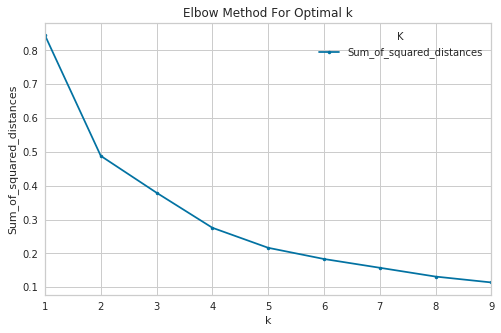

In [67]:
optimal_k.plot(kind = 'line', figsize = (8, 5), marker = '.')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

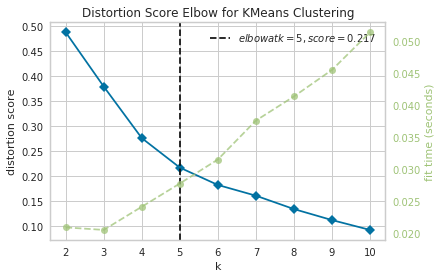

In [68]:
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X)
model.show()

Great! We find that 5 clusters is most optimal number of clusters.  Next we will examine the 5 clusters.

### <a id='item3f'> 3f. Examine the Clusters  </a>

Next we will exmine the clusters to observe the distinguishing categories of each cluster. We will assign each cluster a descriptive name.

### 1. Entertainment Cluster; Cafe's, Restaurants, Bars, and Hotels

In [78]:
dtt_merged.loc[dtt_merged['Cluster Labels'] == 0, dtt_merged.columns[[2] + list(range(5, dtt_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Garden District, Ryerson",0,Clothing Store,Coffee Shop,Japanese Restaurant,Bubble Tea Shop,Cosmetics Shop,Hotel,Café,Diner,Fast Food Restaurant,Italian Restaurant
3,St. James Town,0,Restaurant,Café,Coffee Shop,Cosmetics Shop,American Restaurant,Cocktail Bar,Gastropub,Hotel,Beer Bar,Farmers Market
4,Berczy Park,0,Coffee Shop,Cocktail Bar,Beer Bar,Restaurant,Seafood Restaurant,Farmers Market,Bakery,Pharmacy,Cheese Shop,Café
5,Central Bay Street,0,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Burger Joint,Bar,Salad Place,Bubble Tea Shop,Thai Restaurant
7,"Richmond, Adelaide, King",0,Coffee Shop,Café,Hotel,Restaurant,Gym,Thai Restaurant,Deli / Bodega,Clothing Store,Bakery,Sushi Restaurant
8,"Harbourfront East, Union Station, Toronto Islands",0,Coffee Shop,Aquarium,Café,Hotel,Scenic Lookout,Restaurant,Brewery,Sporting Goods Shop,Fried Chicken Joint,Plaza
9,"Toronto Dominion Centre, Design Exchange",0,Coffee Shop,Hotel,Café,Seafood Restaurant,Japanese Restaurant,Salad Place,American Restaurant,Restaurant,Italian Restaurant,Tea Room
10,"Commerce Court, Victoria Hotel",0,Coffee Shop,Café,Restaurant,Hotel,American Restaurant,Gym,Japanese Restaurant,Italian Restaurant,Deli / Bodega,Seafood Restaurant
11,"University of Toronto, Harbord",0,Café,Bakery,Bar,Japanese Restaurant,Sandwich Place,Restaurant,Bookstore,Dessert Shop,Pub,Chinese Restaurant
12,"Kensington Market, Chinatown, Grange Park",0,Café,Coffee Shop,Dessert Shop,Vietnamese Restaurant,Mexican Restaurant,Vegetarian / Vegan Restaurant,Bar,Park,Bakery,Pizza Place


### 2. Recreation Cluster; Parks, Playgrounds, Trails, Yoda Studio's, and more

In [79]:
dtt_merged.loc[dtt_merged['Cluster Labels'] == 1, dtt_merged.columns[[2] + list(range(5, dtt_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Rosedale,1,Park,Playground,Trail,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


### 3. Cafe and Eatery Cluster; Coffee Shops, Bakeries, Diners, Eateries, some Parks and Yoga

In [80]:
dtt_merged.loc[dtt_merged['Cluster Labels'] == 2, dtt_merged.columns[[2] + list(range(5, dtt_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",2,Coffee Shop,Bakery,Park,Breakfast Spot,Café,Pub,Theater,Yoga Studio,Dessert Shop,Shoe Store
1,"Queen's Park, Ontario Provincial Government",2,Coffee Shop,Diner,Yoga Studio,Burrito Place,Café,Smoothie Shop,Mexican Restaurant,Beer Bar,Italian Restaurant,Bar


### 4. Grocery Cluster; Groceries, Cafe's, Parks Restaurants, and Nightclubs

In [82]:
dtt_merged.loc[dtt_merged['Cluster Labels'] == 3, dtt_merged.columns[[2] + list(range(5, dtt_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Christie,3,Grocery Store,Café,Park,Restaurant,Nightclub,Diner,Candy Store,Italian Restaurant,Baby Store,Coffee Shop


### 5. Airport and Tranportion Cluster; Airport, Boats & Ferry's, Car Rentals, Marina

In [83]:
dtt_merged.loc[dtt_merged['Cluster Labels'] == 4, dtt_merged.columns[[2] + list(range(5, dtt_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,"CN Tower, King and Spadina, Railway Lands, Har...",4,Airport Service,Airport,Boat or Ferry,Coffee Shop,Plane,Rental Car Location,Sculpture Garden,Boutique,Harbor / Marina,Airport Food Court


## Thank you for viewing!